# Predizione del Floor Price di una collezione di NFT


In questo notebook sono contenute tutte le funzioni che abbiamo usato per il nostro modello, i risultati e alcuni commenti per semplificarne la lettura.

La parte del modello ARMA/ARIMA è stata presa da Elena Hoo (https://mirror.xyz/elenahoo.eth/ga8iZLiQPeqLBDXgaAPGVa0TUGfzKJqeAKqfCk3vslI).

Per eseguire il codice basta eseguire tutte le celle in ordine dall'alto verso il basso. Alcune celle possono richiedere qualche accorgimento indicato nei commenti al suo interno.

In [1]:
#import dei pacchetti richiesti.

import requests
import json
import pandas as pd
import numpy as np
import covalent_api as c
import matplotlib.pyplot as plt
from pandas.plotting import lag_plot
import datetime
#from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import accuracy_score, r2_score, precision_score
from PIL import Image
import requests
from io import BytesIO
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.ar_model import ar_select_order
from datetime import datetime

plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':300})

In [2]:
def fetch_collection_hist(address):
    api_url = 'https://api.covalenthq.com'
    endpoint = f'/v1/1/nft_market/collection/{address}/'
    url = api_url + endpoint
    r = requests.get(url, auth=(auth_key,''))
    input_data = r.json()
    input_data = input_data['data']['items']
    out = pd.DataFrame.from_records(input_data)
    return(out)

def stationary_test(x):

    out = adfuller(x.dropna())
    print('ADF Statistic: %f' % out[0])
    print('p-value: %f' % out[1])
    if out[1] <= 0.05:
        print('Time-series is stationary at 5% significance level.')
    else:
        print('Time-series is non-stationary at 5% significance level. Find the order of difference!')

# Accuracy metrics
def accuracy(y_hat, y):
    mape = np.mean(np.abs(y_hat - y)/np.abs(y))     
    rmse = np.mean((y_hat - y)**2)**0.5
    corr = np.corrcoef(y_hat, y)[0,1]   


    return({'Mean absolute percentage error':mape
            , 'Root mean squared error':rmse
            , 'corr':corr})

In [3]:
## chiave di autorizzazione dell'API Covalent. Nel nostro caso i dati sono già scaricati e formattati nel file monkey_pickle.pkl ma lasciamo questa cella per chiarezza.
auth_key = 'inserisci_la_chiave'

## Preparazione dei dati

Inserendo qua sotto un indirizzo del wallet di una collezione di NFT è possibile ottenere i dati relativi a quest'ultima. Tutti i nostri esempi useranno Bored Ape Yacht Club (BAYC) e i dati sono già stati scaricati e salvati su un file pickle. La chiamata di funzione e la pulizia dei dati sono comunque stati lasciati (commentati) nella cella dove vengono caricati i dati dal file locale.

Al termine di questo gruppo di celle la variabile data contiene i dati raccolti da Covalent che saranno usati in tutti i nostri modelli.

In [4]:
#indirizzo del wallet della collezione scelta. Nel nostro caso: Bored Ape Yacht Club.
nft_address = '0xbc4ca0eda7647a8ab7c2061c2e118a18a936f13d'
#'0xb47e3cd837dDF8e4c57F05d70Ab865de6e193BBB' Cryptopunks
#'0x73DA73EF3a6982109c4d5BDb0dB9dd3E3783f313' My Curio Cards
#'0xc3f733ca98E0daD0386979Eb96fb1722A1A05E69' Moon Cats
#'0xA08126f5E1ED91A635987071E6FF5EB2aEb67C48' Galaxy Eggs

In [5]:
## Funzioni per raccogliere i dati relativi a una collezione e pulirli in modo da potreli usare nei nostri modelli. ##

#data = fetch_collection_hist(nft_address)
#data['opening_date'] = pd.to_datetime(data['opening_date'])
#data = data.sort_values(by='opening_date', ascending=True)
#data.set_index('opening_date', inplace=True)

data = pd.read_pickle("./monkey_pickle.pkl")
print(data)

              chain_id    collection_name  \
opening_date                                
2021-04-30           1  BoredApeYachtClub   
2021-05-01           1  BoredApeYachtClub   
2021-05-02           1  BoredApeYachtClub   
2021-05-03           1  BoredApeYachtClub   
2021-05-04           1  BoredApeYachtClub   
...                ...                ...   
2022-04-02           1  BoredApeYachtClub   
2022-04-03           1  BoredApeYachtClub   
2022-04-04           1  BoredApeYachtClub   
2022-04-05           1  BoredApeYachtClub   
2022-04-06           1  BoredApeYachtClub   

                                      collection_address  \
opening_date                                               
2021-04-30    0xbc4ca0eda7647a8ab7c2061c2e118a18a936f13d   
2021-05-01    0xbc4ca0eda7647a8ab7c2061c2e118a18a936f13d   
2021-05-02    0xbc4ca0eda7647a8ab7c2061c2e118a18a936f13d   
2021-05-03    0xbc4ca0eda7647a8ab7c2061c2e118a18a936f13d   
2021-05-04    0xbc4ca0eda7647a8ab7c2061c2e118a18a936f1

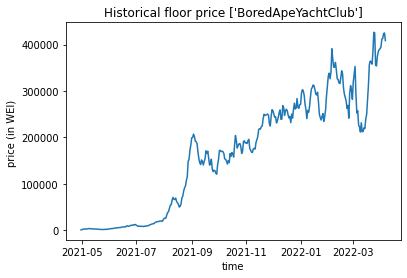

In [6]:
## Grafico che mostra l'andamento del floor price della collezione ovvero i nostri dati. Il periodo di tempo interessato è quello tra il 30/04/2021 e il 06/04/2022##
name = np.unique(data['collection_name']).tolist()
plt.plot( data["floor_price_quote_7d"])
plt.title("Historical floor price "+str(name))
plt.xlabel("time")
plt.ylabel("price (in WEI) ")
plt.show()

## MODELLO AR
Questo modello, un caso particolare del modello ARMA, è la rappresentazione di un tipo di processo stocastico, è lineare e in questo caso viene usato come step precedente ad ARMA per vedere se con questa tecnica riusciamo ad ottenere un risultato soddisfacente.

c:\Users\Simone\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Simone\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Simone\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\Simone\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position 

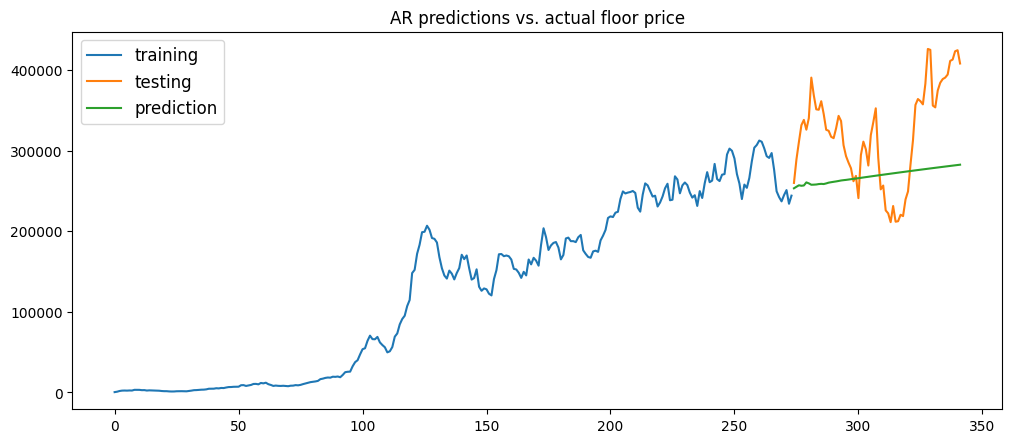

In [7]:
## dobbiamo rifinire i dati per questo modello. Prendiamo in considerazione solo il floor price e facciamo uno split del dataset per training e testing. 
#  80% dei dati sono training e gli altri 20% sono testing. Questo split è coerente con quello del modello ARMA che vedremo successivamente.

a_data = data.floor_price_quote_7d

split = round(len(a_data)*0.8)
a_train = a_data[:split]
a_test = a_data[split:]

## a_res è il nostro modello dopo la funzione di fitting. La funzione ar_select_order sceglie automaticamente i lag più adatti per il modello in base ai dati.
#  pdict contiene le predizioni nello stesso timeframe dei dati di testing per avere un confronto.
a_res = AutoReg(a_train, lags=ar_select_order(a_train, maxlag=20, ic='aic').ar_lags).fit()
pdict = a_res.predict(start=datetime(2022, 1, 29), end=datetime(2022, 4, 6), dynamic=False)


## da qui in avanti in questa cella il codice serve per preparare i dati per essere visualizzati nel loro grafico.
#  Rimuoviamo le date per avere dati più omogenei e diamo a tutti i dati lo stesso indice,
#  ovvero il numero di dati da rappresentare.
a_idx = np.arange(len(a_train), len(a_train) + len(a_test))
a_test_pred = pd.Series(pdict.values, index = a_idx)

a_plot_train = a_train.reset_index()
a_plot_test = pd.DataFrame(a_test).set_index(a_idx)
a_plot_pred = pd.DataFrame(a_test_pred).set_index(a_idx)

plt.figure(figsize=(12,5), dpi=100)
plt.plot(a_plot_train.floor_price_quote_7d, label = "training")
plt.plot(a_plot_test.floor_price_quote_7d, label = "testing")
plt.plot(a_plot_pred, label = "prediction")
plt.legend(loc='upper left', fontsize = 12)
plt.title("AR predictions vs. actual floor price")
plt.show()

## MODELLO ARIMA
I modelli di questo tipo sono quelli più generali per predirre una serie temporale. Il modello ARIMA(p,d,q) ha tre componenti:
- **p** è il numero di termini auto-regressivi.
- **d** è il numero di differenze necessarie per la stazionarietà.
- **q** è il numero di errori nell'equazione di previsione.

Nelle celle successive prepariamo il modello ARIMA all'utilizzo, controlliamo che le ipotesi per il suo funzionamento siano verificate e creiamo un grafico per visualizzare i risultati.

In [8]:
## Split tra i dati di training e i dati di test per il modello ARMA/ARIMA
train_size = round(len(data)*0.8)

train = data.floor_price_quote_7d[:train_size]
test = data.floor_price_quote_7d[train_size:]

In [9]:
##La funzione auto_arima costruisce un modello ARIMA automaticamente in base ai dati e i parametri inseriti. 
model = pm.auto_arima(train, start_p=1, start_q=1,
                      test='adf', #usiamo il test adf per la stazionarietà.      
                      max_p=5, max_q=5,              
                      d=None, #ordine della prima differenziazione          
                      seasonal=False,   
                      trace=True, #Stampa lo status dei fit.
                      suppress_warnings=True, 
                      stepwise=True, #usiamo l'algoritmo stepwise.
                      random_state=42)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=5729.675, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=5735.080, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=5728.820, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=5728.163, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5735.909, Time=0.00 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=5729.880, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=5731.750, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=5728.210, Time=0.01 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 0.176 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  274
Model:               SARIMAX(0, 1, 1)   Log Likelihood               -2861.081
Date:                Sat, 10 Sep 2022   AIC                           5728.163
Time:                        11:50:0

#### Predizione
Usiamo il modello che abbiamo costruito a partire dai dati relativi al periodo tra il 30/04/2021 e il 28/01/2022 per predire i Floor Price relativi all'intervallo tra il 29/01/202 e il 06/04/2022.

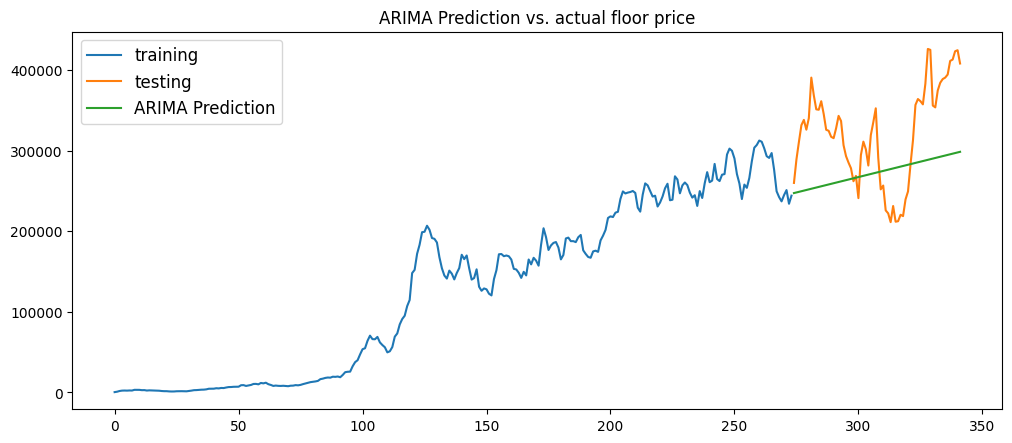

In [11]:
##funzioni che predicono i risultati e creano il grafico per visualizzare qeuste previsioni.
pred, ci = model.predict(n_periods = len(test), return_conf_int=True)
idx = np.arange(len(train), len(train) + len(test))

test_pred = pd.Series(pred, index = idx)

# Plot
plot_train = train.reset_index()
plot_test = pd.DataFrame(test).set_index(idx)
plot_pred = pd.DataFrame(test_pred).set_index(idx)

plt.figure(figsize=(12,5), dpi=100)
plt.plot(plot_train.floor_price_quote_7d, label = "training")
plt.plot(plot_test.floor_price_quote_7d, label = "testing")
plt.plot(plot_pred, label = "ARIMA Prediction")
plt.legend(loc='upper left', fontsize = 12)
plt.title("ARIMA Prediction vs. actual floor price")
plt.show()


## PARAGONE TRA I MODELLI
Questo grafico serve a evidenziare le differenze tra i risultati dei due modelli. Vediamo che il modello ARIMA nel nostro caso segue il trend meglio ma questi modelli riescono solo a indovinare l'andamento generale dei dati. Per risultati più precisi servono altri modelli, magari con più variabili considerate.

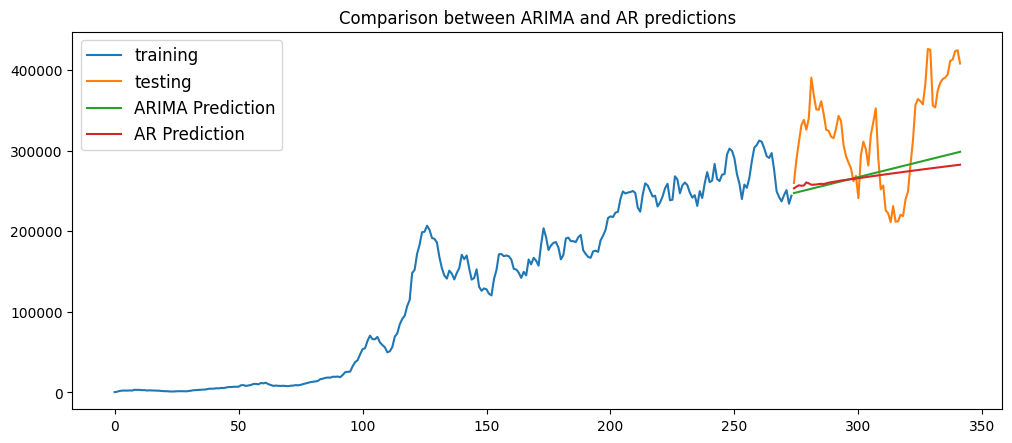

In [12]:
plt.figure(figsize=(12,5), dpi=100)
plt.plot(plot_train.floor_price_quote_7d, label = "training")
plt.plot(plot_test.floor_price_quote_7d, label = "testing")
plt.plot(plot_pred, label = "ARIMA Prediction")
plt.plot(a_plot_pred, label = "AR Prediction")
plt.legend(loc='upper left', fontsize = 12)
plt.title("Comparison between ARIMA and AR predictions")
plt.show()

## Performance
Calcoliamo la performace del modello ARIMA nella cella successiva. L'errore medio è così alto a causa dei valori giganti del floor price nei dati. Un WEI infatti è equivalente a 0,000000000000000001 ETH, rendendo tutti i prezzi altissimi.


In [13]:
## funzioni per calcolare la performance del modello.
actual = pd.DataFrame(test).reset_index()
actual.columns = ['date','actual']

predict = pd.DataFrame(test_pred).reset_index()
predict.columns = ['date','predict']

accuracy(predict['predict'], actual['actual'])

{'Mean absolute percentage error': 0.19894706076688498,
 'Root mean squared error': 74919.89346455934,
 'corr': 0.2957063761541203}